# 2주차 - 고객 대출등급 분류 해커톤

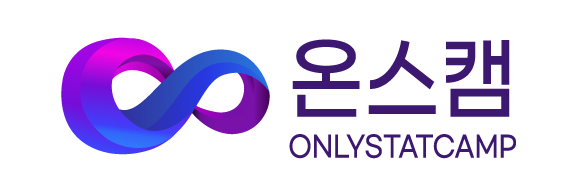

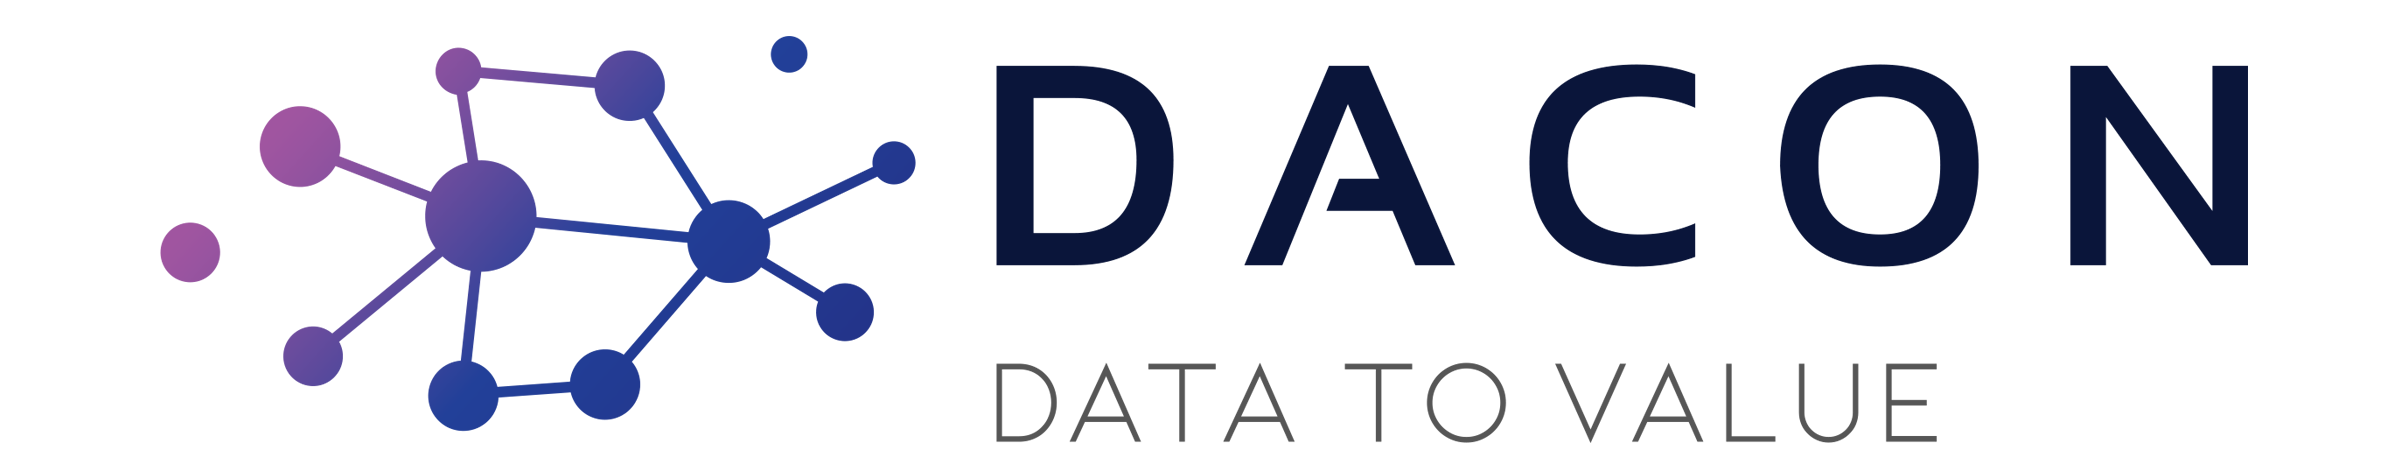

---

In [1]:
import os
import random

In [2]:
import numpy as np
import pandas as pd

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

random.seed(42)
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = "42"

In [4]:
import warnings 

# 경고 메시지 숨기기
warnings.filterwarnings("ignore")

# 경고 메시지 나타내기 (=기본 설정)
# warnings.filterwarnings("default")

In [5]:
from tqdm.auto import tqdm

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [8]:
import tensorflow as tf

2024-01-21 21:54:43.783382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-21 21:54:44.421547: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/juing/app/TensorRT-7.2.3.4/lib:/usr/lib/nvidia:/home/juing/.mujoco/mujoco210/bin:/usr/local/cuda-11.2/extras/CUPTI/lib64:/usr/local/cuda-11.2/lib64
2024-01-21 21:54:44.421700: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory

---

# 데이터 준비

## 데이터 설명

- Dataset Info.

- train.csv [파일] 
    - 고객 관련 금융 정보
    - ID : 대출 고객의 고유 ID
    - 대출등급 : 예측 목표


- test.csv [파일]
    - 고객 관련 금융 정보
    - ID : 대출 고객의 고유 ID
    - 대출등급이 존재하지 않음


- sample_submission.csv [파일] - 제출 양식
    - ID : 대출 고객의 고유 ID
    - 대출등급 : test.csv에서 제공된 고객의 대출등급을 예측하여 기입

---

## 데이터 불러오기

### train

In [9]:
train_df = pd.read_csv("../data/고객대출등급분류/train.csv")

In [10]:
train_df.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            96294 non-null  object 
 1   대출금액          96294 non-null  int64  
 2   대출기간          96294 non-null  object 
 3   근로기간          96294 non-null  object 
 4   주택소유상태        96294 non-null  object 
 5   연간소득          96294 non-null  int64  
 6   부채_대비_소득_비율   96294 non-null  float64
 7   총계좌수          96294 non-null  int64  
 8   대출목적          96294 non-null  object 
 9   최근_2년간_연체_횟수  96294 non-null  int64  
 10  총상환원금         96294 non-null  int64  
 11  총상환이자         96294 non-null  float64
 12  총연체금액         96294 non-null  float64
 13  연체계좌수         96294 non-null  float64
 14  대출등급          96294 non-null  object 
dtypes: float64(4), int64(5), object(6)
memory usage: 11.0+ MB


In [12]:
train_df.describe()

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,9.629400e+04,9.629400e+04,96294.000000,96294.000000,96294.000000,9.629400e+04,9.629400e+04,96294.000000,96294.000000
mean,1.830400e+07,9.392672e+07,19.379590,25.304827,0.345681,8.225035e+05,4.282282e+05,54.380584,0.005805
std,1.032908e+07,9.956871e+07,33.569559,12.088566,0.919119,1.027745e+06,4.402111e+05,1414.769218,0.079966
min,1.200000e+06,0.000000e+00,0.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.020000e+07,5.760000e+07,12.650000,17.000000,0.000000,3.075720e+05,1.346160e+05,0.000000,0.000000
50%,1.680000e+07,7.800000e+07,18.740000,24.000000,0.000000,5.976960e+05,2.870040e+05,0.000000,0.000000
75%,2.400000e+07,1.128000e+08,25.540000,32.000000,0.000000,1.055076e+06,5.702160e+05,0.000000,0.000000
max,4.200000e+07,1.080000e+10,9999.000000,169.000000,30.000000,4.195594e+07,5.653416e+06,75768.000000,4.000000


In [13]:
Grade2Label = {
    "A" : 0,
    "B" : 1,
    "C" : 2,
    "D" : 3,
    "E" : 4,
    "F" : 5,
    "G" : 6,
}

In [14]:
Label2Grade = {v : k for k, v in Grade2Label.items()}

In [15]:
train_df["대출등급"] = train_df.대출등급.apply(lambda x: Grade2Label[x])

### test

In [16]:
test_df = pd.read_csv("../data/고객대출등급분류/test.csv")

In [17]:
test_df.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,TEST_00000,16800000,36 months,8 years,MORTGAGE,132000000,19.64,12,주택 개선,0,394692,146604.0,0.0,0.0
1,TEST_00001,8400000,36 months,5 years,RENT,89971200,15.84,25,부채 통합,0,0,0.0,0.0,0.0
2,TEST_00002,17280000,36 months,6 years,RENT,150000000,8.41,20,신용 카드,0,1786980,281820.0,0.0,0.0
3,TEST_00003,14400000,36 months,5 years,MORTGAGE,66000000,13.72,30,신용 카드,1,669024,281724.0,0.0,0.0
4,TEST_00004,27600000,36 months,5 years,RENT,55200000,30.50,12,신용 카드,0,1250052,614844.0,0.0,0.0


In [18]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64197 entries, 0 to 64196
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            64197 non-null  object 
 1   대출금액          64197 non-null  int64  
 2   대출기간          64197 non-null  object 
 3   근로기간          64197 non-null  object 
 4   주택소유상태        64197 non-null  object 
 5   연간소득          64197 non-null  int64  
 6   부채_대비_소득_비율   64197 non-null  float64
 7   총계좌수          64197 non-null  int64  
 8   대출목적          64197 non-null  object 
 9   최근_2년간_연체_횟수  64197 non-null  int64  
 10  총상환원금         64197 non-null  int64  
 11  총상환이자         64197 non-null  float64
 12  총연체금액         64197 non-null  float64
 13  연체계좌수         64197 non-null  float64
dtypes: float64(4), int64(5), object(5)
memory usage: 6.9+ MB


---

In [19]:
sample_submission = pd.read_csv("../data/고객대출등급분류/sample_submission.csv")

In [20]:
sample_submission

,ID,대출등급
0,TEST_00000,G
1,TEST_00001,G
2,TEST_00002,G
3,TEST_00003,G
4,TEST_00004,G
...,...,...
64192,TEST_64192,G
64193,TEST_64193,G
64194,TEST_64194,G
64195,TEST_64195,G


---

## 데이터 전처리

데이터 전처리 단계에서는 수치형 데이터의 정규화, 범주형 데이터의 원-핫 인코딩, 결측치 처리 등을 수행합니다. 대출등급이 타겟 변수이므로, 이를 제외한 다른 특성들을 입력 변수로 사용할 것입니다.

In [21]:
# 범주형 데이터와 수치형 데이터 분리
categorical_cols = train_df.select_dtypes(include=['object']).columns
numeric_cols = train_df.select_dtypes(exclude=['object']).columns

In [22]:
categorical_cols 

Index(['ID', '대출기간', '근로기간', '주택소유상태', '대출목적'], dtype='object')

In [23]:
numeric_cols

Index(['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자',
       '총연체금액', '연체계좌수', '대출등급'],
      dtype='object')

In [24]:
categorical_cols = [
    '대출기간', '근로기간', '주택소유상태', '대출목적'
]

In [25]:
train_df[categorical_cols]

,대출기간,근로기간,주택소유상태,대출목적
0,36 months,6 years,RENT,부채 통합
1,60 months,10+ years,MORTGAGE,주택 개선
2,36 months,5 years,MORTGAGE,부채 통합
3,36 months,8 years,MORTGAGE,부채 통합
4,60 months,Unknown,RENT,주요 구매
...,...,...,...,...
96289,36 months,10+ years,MORTGAGE,신용 카드
96290,60 months,10+ years,MORTGAGE,주택 개선
96291,36 months,1 year,MORTGAGE,신용 카드
96292,36 months,5 years,MORTGAGE,부채 통합


In [26]:
numeric_cols = [
    '대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'
]

In [27]:
train_df[numeric_cols]

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,12480000,72000000,18.90,15,0,0,0.0,0.0,0.0
1,14400000,130800000,22.33,21,0,373572,234060.0,0.0,0.0
2,12000000,96000000,8.60,14,0,928644,151944.0,0.0,0.0
3,14400000,132000000,15.09,15,0,325824,153108.0,0.0,0.0
4,18000000,71736000,25.39,19,0,228540,148956.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
96289,14400000,210000000,9.33,33,0,974580,492168.0,0.0,0.0
96290,28800000,132000000,5.16,25,0,583728,855084.0,0.0,0.0
96291,14400000,84000000,11.24,22,0,1489128,241236.0,0.0,0.0
96292,15600000,66330000,17.30,21,2,1378368,818076.0,0.0,0.0


## 돈과 관련된 데이터

In [28]:
train_df[numeric_cols].describe()

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,9.629400e+04,9.629400e+04,96294.000000,96294.000000,96294.000000,9.629400e+04,9.629400e+04,96294.000000,96294.000000
mean,1.830400e+07,9.392672e+07,19.379590,25.304827,0.345681,8.225035e+05,4.282282e+05,54.380584,0.005805
std,1.032908e+07,9.956871e+07,33.569559,12.088566,0.919119,1.027745e+06,4.402111e+05,1414.769218,0.079966
min,1.200000e+06,0.000000e+00,0.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.020000e+07,5.760000e+07,12.650000,17.000000,0.000000,3.075720e+05,1.346160e+05,0.000000,0.000000
50%,1.680000e+07,7.800000e+07,18.740000,24.000000,0.000000,5.976960e+05,2.870040e+05,0.000000,0.000000
75%,2.400000e+07,1.128000e+08,25.540000,32.000000,0.000000,1.055076e+06,5.702160e+05,0.000000,0.000000
max,4.200000e+07,1.080000e+10,9999.000000,169.000000,30.000000,4.195594e+07,5.653416e+06,75768.000000,4.000000


In [29]:
train_df["대출금액"] = np.log(train_df["대출금액"] + 1)
train_df["연간소득"] = np.log(train_df["연간소득"] + 1)
train_df["총상환원금"] = np.log(train_df["총상환원금"] + 1)
train_df["총상환이자"] = np.log(train_df["총상환이자"] + 1)

In [30]:
train_df[numeric_cols].describe()

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,96294.000000,96294.000000,96294.000000,96294.000000,96294.000000,96294.000000,96294.000000,96294.000000,96294.000000
mean,16.533311,18.198796,19.379590,25.304827,0.345681,12.583618,11.890929,54.380584,0.005805
std,0.667026,0.540068,33.569559,12.088566,0.919119,3.176492,3.058164,1414.769218,0.079966
min,13.997833,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.137898,17.869033,12.650000,17.000000,0.000000,12.636468,11.810189,0.000000,0.000000
50%,16.636890,18.172219,18.740000,24.000000,0.000000,13.300839,12.567255,0.000000,0.000000
75%,16.993564,18.541127,25.540000,32.000000,0.000000,13.869124,13.253772,0.000000,0.000000
max,17.553180,23.102812,9999.000000,169.000000,30.000000,17.552131,15.547771,75768.000000,4.000000


In [31]:
test_df["대출금액"] = np.log(test_df["대출금액"] + 1)
test_df["연간소득"] = np.log(test_df["연간소득"] + 1)
test_df["총상환원금"] = np.log(test_df["총상환원금"] + 1)
test_df["총상환이자"] = np.log(test_df["총상환이자"] + 1)

### 모델을 훈련하기 위해 선택한 train_test_split

In [32]:
train, valid = train_test_split(train_df, 
                              test_size=0.1, 
                              random_state=42,
                              stratify=train_df.대출등급)

### 수치형 데이터 정규화

### fit

In [33]:
scaler = StandardScaler()
scaler.fit(train[numeric_cols])

StandardScaler()

In [34]:
scaler.mean_

array([1.65322217e+01, 1.81984277e+01, 1.92791706e+01, 2.52892435e+01,
       3.46937598e-01, 1.25841010e+01, 1.18916830e+01, 5.33613957e+01,
       5.90787409e-03])

In [35]:
scaler.scale_

array([6.67524272e-01, 5.36393030e-01, 9.72100498e+00, 1.20811218e+01,
       9.21636665e-01, 3.17614182e+00, 3.05751594e+00, 1.39537578e+03,
       8.10265395e-02])

### transform

In [36]:
train_scaled_numeric = scaler.transform(train[numeric_cols])
valid_scaled_numeric = scaler.transform(valid[numeric_cols])
test_scaled_numeric = scaler.transform(test_df[numeric_cols])

In [37]:
print(train_scaled_numeric.shape)
print(valid_scaled_numeric.shape)
print(test_scaled_numeric.shape)

(86664, 9)
(9630, 9)
(64197, 9)


### 범주형 데이터 원-핫 인코딩

In [38]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(train[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False)

In [39]:
train.주택소유상태.value_counts()

MORTGAGE    43105
RENT        33935
OWN          9624
Name: 주택소유상태, dtype: int64

In [40]:
valid.주택소유상태.value_counts()

MORTGAGE    4829
RENT        3770
OWN         1030
ANY            1
Name: 주택소유상태, dtype: int64

In [41]:
train_encoded_categorical_df = encoder.transform(train[categorical_cols])
valid_encoded_categorical_df = encoder.transform(valid[categorical_cols])
test_encoded_categorical_df = encoder.transform(test_df[categorical_cols])

In [42]:
print(train_encoded_categorical_df.shape)
print(valid_encoded_categorical_df.shape)
print(test_encoded_categorical_df.shape)

(86664, 33)
(9630, 33)
(64197, 33)


---

In [43]:
train_x = np.concatenate([train_scaled_numeric, train_encoded_categorical_df], axis=1)
valid_x = np.concatenate([valid_scaled_numeric, valid_encoded_categorical_df], axis=1)
test_x = np.concatenate([test_scaled_numeric, test_encoded_categorical_df], axis=1)

In [44]:
print(train_x.shape)
print(valid_x.shape)
print(test_x.shape)

(86664, 42)
(9630, 42)
(64197, 42)


In [45]:
train_y = np.array(train.대출등급).reshape(-1, 1)
valid_y = np.array(valid.대출등급).reshape(-1, 1)

In [46]:
print(train_y.shape)
print(valid_y.shape)

(86664, 1)
(9630, 1)


---

# Model 빌드하기

## 1.  Sequential API 

* 가장 간단하고 쉬운 방법입니다.
* 모델이 순차적인 층(layer)의 스택으로 구성될 때 사용하기 좋습니다.
* 복잡한 모델을 만드는 데에는 제한이 있습니다 (예: 다중 입력이나 출력, 층 간의 복잡한 연결 등).

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization

In [48]:
num_classes = len(Grade2Label)

In [49]:
model = Sequential([
    ########################################
    Dense(1024, input_shape=(42, )),
    Activation("relu"),
    Dropout(0.5),
    ########################################
    Dense(1024, input_shape=(42, )),
    Activation("relu"),
    Dropout(0.5),
    ########################################
    Dense(num_classes),
    Activation("softmax"),
])

2024-01-21 21:54:46.364378: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [50]:
def f1_loss(y_true, y_pred):
    y_pred = np.argmax(y_pred, 1)
    f1_scores = []
    for c in range(num_classes):
        y_true_c = (y_true == c)
        y_pred_c = (y_pred == c)
        f1_c = f1_score(y_true_c, y_pred_c)
        f1_scores.append(f1_c)
    return -np.mean(f1_scores)

In [51]:
def custome_metric(y_true, y_pred):
    f1 = tf.py_function(func=f1_loss, inp=[y_true, y_pred], Tout=tf.float32)
    return f1

In [52]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[
                  tf.keras.metrics.SparseCategoricalAccuracy(), 
                  custome_metric
              ])

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              44032     
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 activation_1 (Activation)   (None, 1024)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 7)                 7

---

# 모델 학습

## 1.  Sequential API 

In [54]:
history = model.fit(x=train_x, 
                    y=train_y,  
                    batch_size=128, 
                    epochs=100, 
                    validation_data=(valid_x, valid_y))

Epoch 1/100
678/678 [==============================] - 16s 23ms/step - loss: 1.0391 - sparse_categorical_accuracy: 0.5684 - custome_metric: -0.3945 - val_loss: 0.7140 - val_sparse_categorical_accuracy: 0.7468 - val_custome_metric: -0.5829
Epoch 2/100
678/678 [==============================] - 16s 23ms/step - loss: 0.7120 - sparse_categorical_accuracy: 0.7286 - custome_metric: -0.5654 - val_loss: 0.6499 - val_sparse_categorical_accuracy: 0.7562 - val_custome_metric: -0.5808
Epoch 3/100
678/678 [==============================] - 16s 23ms/step - loss: 0.6521 - sparse_categorical_accuracy: 0.7431 - custome_metric: -0.5838 - val_loss: 0.6401 - val_sparse_categorical_accuracy: 0.7469 - val_custome_metric: -0.6130
Epoch 4/100
678/678 [==============================] - 16s 23ms/step - loss: 0.6198 - sparse_categorical_accuracy: 0.7571 - custome_metric: -0.5974 - val_loss: 0.5581 - val_sparse_categorical_accuracy: 0.8059 - val_custome_metric: -0.6539
Epoch 5/100
678/678 [=======================

In [55]:
history_df = pd.DataFrame(history.history)

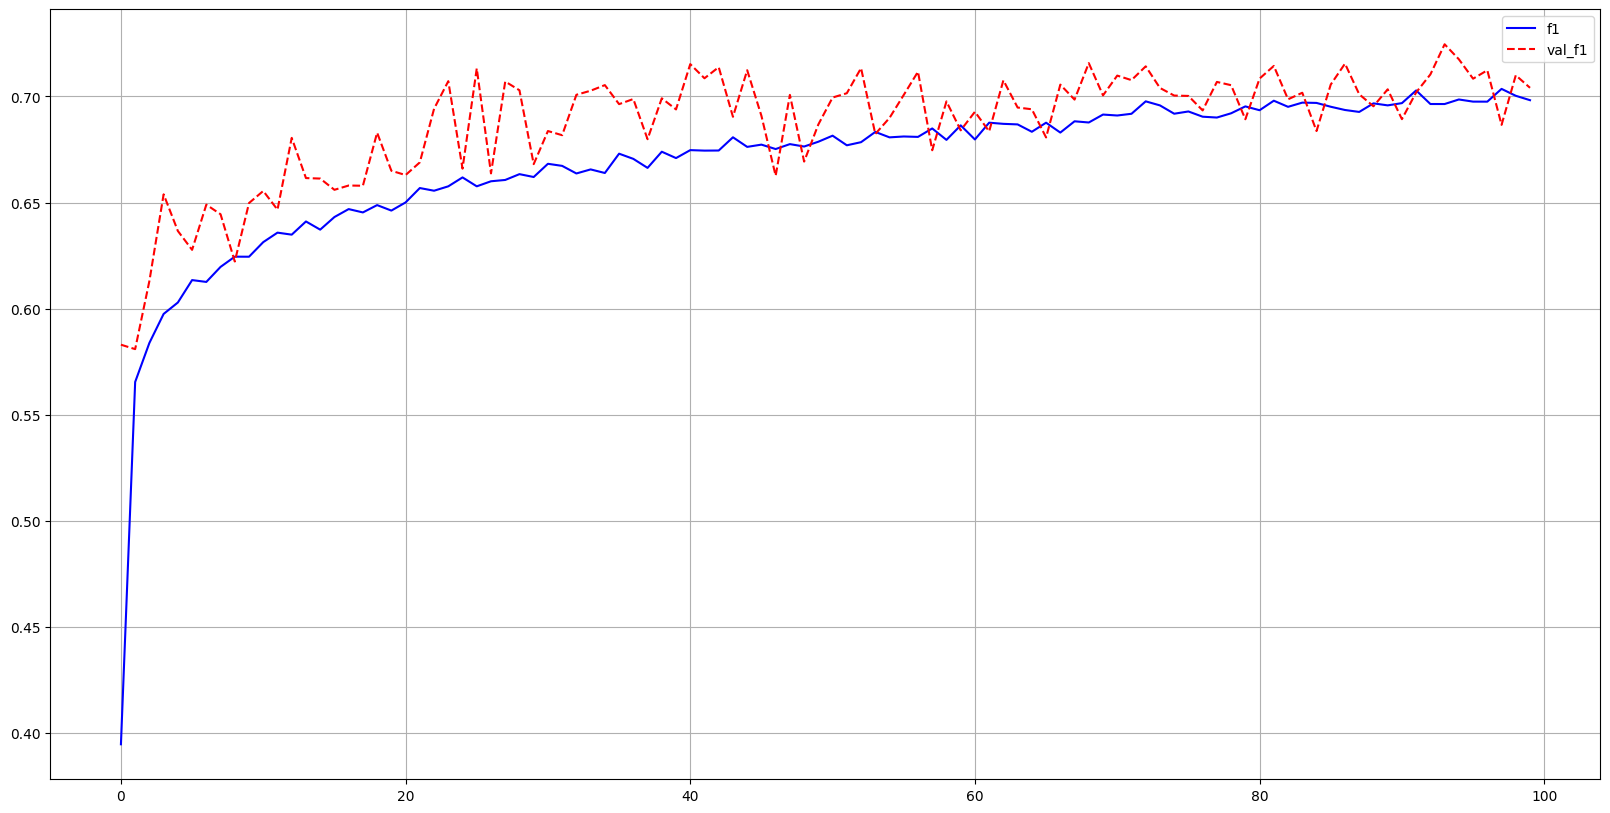

In [66]:
plt.figure(figsize=(20, 10))
plt.plot(-history_df['custome_metric'], 'b-', label='f1')
plt.plot(-history_df['val_custome_metric'], 'r--', label='val_f1')
plt.legend()
plt.grid()
plt.show()

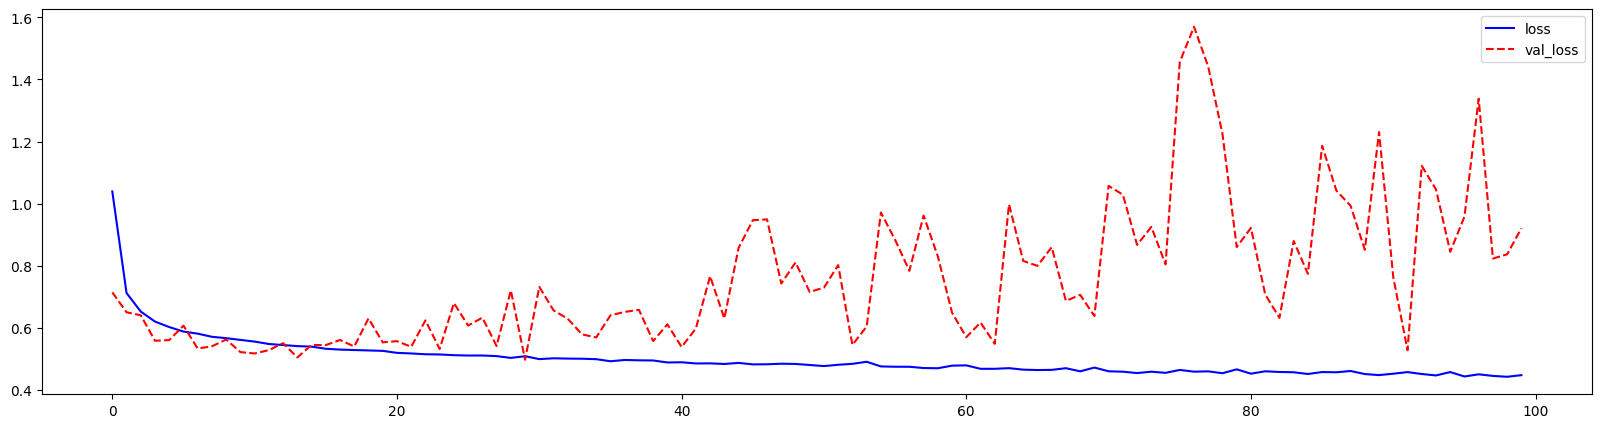

In [65]:
plt.figure(figsize=(20, 5))
plt.plot(history_df['loss'], 'b-', label='loss')
plt.plot(history_df['val_loss'], 'r--', label='val_loss')
plt.legend()
plt.show()

# 추론 수행하기

### sequential_model

In [58]:
model.evaluate(x=valid_x, y=valid_y)

301/301 [==============================] - 7s 23ms/step - loss: 0.9206 - sparse_categorical_accuracy: 0.8249 - custome_metric: -0.6141


[0.9205790162086487, 0.8249221444129944, -0.6141213774681091]

In [59]:
val_pred = model.predict(valid_x)

301/301 [==============================] - 1s 3ms/step


In [60]:
y_true = np.array(valid_y)
y_pred = np.argmax(val_pred, 1)

In [61]:
def macro_f1_score(y_true, y_pred, n_classes):
    f1_scores = []
    for c in range(n_classes):
        y_true_c = (y_true == c)
        y_pred_c = (y_pred == c)
        f1_c = f1_score(y_true_c, y_pred_c)
        f1_scores.append(f1_c)
    return np.mean(f1_scores)

In [62]:
macro_f1 = macro_f1_score(y_true, y_pred, num_classes)
print("Macro F1 Score:", macro_f1)

Macro F1 Score: 0.7818805165351662


---

# sample_submission




In [63]:
pred = model.predict(test_x)

pred = np.argmax(pred, 1)

sample_submission["대출등급"] = [Label2Grade[i] for i in pred]

sample_submission

sample_submission.to_csv('../data/고객대출등급분류/baseline_submit.csv', index=False)

2007/2007 [==============================] - 6s 3ms/step


---